# 1. Project Motivation

I wanted to choose a subject that uses a physics model to simulate a market model. This type of field of research is called 'econo-physics' and has gained some reputation over the last couple of decades. 
\\
A few papers apply a modified Ising model to simulate an agent-based market model. \\
Namely, this paper from Bornholdt [1] from 2001 explores 'frustrated' dynamics of the model, where each agent (i.e spin) is motivated by two major conflicting forces : 
- Following its neighbors : Herd behavior

- Following the minority : Traders with information are part of the minority 
This different approach interprets each spin of the Ising lattice as an agent, where a spin $+1$ corresponds to a buy, and a spin $-1$ corresponds to a sell. \\
Thus, we can consider the evolution of the model as the evolution of the interacting agent strategies, where the magnetization of the model corresponds to the evolution of price.

When analyzing the evolution of an asset, we often look at the evolution of the log-return. It has been shown in Ref [2] that this log-return is proportional to the value $r(t)=M(t)-M(t-1)$ in our Ising model simulation. 

The main factor that determines the behavior of $r(t)$ when running an Ising model is the temperature $T$ under which our model evolves. 
Whether $T$ is below or above the critical temperature $T_c$ determines the behavior : 
Below the critical temperature in the Ising model, spins align to create long-range order and spontaneous symmetry breaking, while above it, thermal fluctuations dominate, leading to random spin orientations and the absence of long-range order or symmetry breaking.

Since in financial analysis we can easily observe the log-returns of an asset, I wanted to build a supervised model that is trained on the generated data $r(t)$ from an Ising model simulation and its temperature label. The model should then be able to infer whether a given time-series $r(t)$ is evolving below, around or above the critical temperature $T_c$. 

I find it interesting to determine $T_c$ in this context, as it has not been done before in this way. (I have seen it for interpreting an Ising grid, but the financial context behind it has never been explored for this problem). $T_c$ in this context can be interpreted as the reactiveness of the market. 
Indeed, below the critical temperature $T_c$, the market is less random and more correlated, leading to stable phases punctuated by sudden bursts of volatility resembling financial bubbles and crashes. Around and above $T_c$, the market transitions to more chaotic and less predictable behavior with increased fluctuations, while significantly above $T_c$, higher randomness leads to diminished correlations among traders, resulting in a more stable but individually driven market dynamic.

Thus using a model to infer the so called 'market temperature' based on asset's log-returns analysis can be a pertinent tool to estimate the behavior of the current market.

Generated data from Ising follows a similar distribution from real-world data, hence the interest in such a simulation.

# 2. Literature Review

The main inspiration for this framework is the Bornholdt paper from 2001 [1]. This paper applies an Ising spin-model to perform agent-based market analysis. It aims to demonstrate how market phenomena like volatility and extreme market events can be interpreted by focusing on the interaction among traders and the effect of their behavior on market dynamics.

Many papers have since developed further on this model, including some later papers of himself ([3]).

Some papers take it way further in the financial analysis such as [5], which is not the angle I chose to approach this.

The paper from Ref [4] takes a similar approach to mine by determining the (hyper)parameters of the Ising model, although no Machine Learning is used.

Finally, this presentation form University of Warwick is where the idea of using a MLP Classifier to class temperatures of the Ising model as below, close to, or above $T_c$ came from. 
To avoid plagiarism on this document, I made two big changes that make their code implementation useless : 

- I'm using Pytorch instead of Keras
- My input dataset are a time-series of log-returns instead of the Ising grid


# 3. Dataset

## Background context

As mentioned before, my dataset is as follows :
- A time series representing the log-return extracted from the Ising model simulation $r(t) = M(t)-M(t-1)$.
- The value of the temperature $T$ under which this Ising simulation was ran

The dataset needs to go through some pre-processing to be able to be fed to the Neural network, as we'll see later.

## Source

My dataset has been generated from running an Ising model at several different temperatures ranging from $0.1*T_c$ to $5.0 *T_c$. Temperatures are then classified into 3 categories : 
- below $T_c$ if $T,0.75*T_c$
- around $T_c$ if $0.75*T_c< T < 1.45*T_c$
- above $T_c$ if $T> 1.45*T_c$ 
The total dataset is of only 2100 elements due to the time it takes to run each Ising simulation. However some tricks allow us to get more of it.

The generated data is noisy due to the nature of the Ising model simulation and its inclusion of MCMC .
However, for this same reason the data is not generated quickly, at around 5 data points per minute, thus I was able to fit 2100 data points into an h5 file of less than 10MB. 

## Describing the Dataset

The input features of my dataset are the time series and temperature class corresponding to each time series.

Some pre-processing is required to make the most of this dataset. 
First of all I applied a window function to make multiple smaller time series out of each one, making smaller time-series and thus creating a larger dataset to feed the model.

To improve performance, I added features to the dataset : minimum and maximum values, mean, and standard deviation to measure relevant characteristics of the time-series.

The noisiness of the model is a desired behavior, since simulating a market must come with noise, and that high deviations are one of the most relevant features to estimate temperatures. 

So, choosing a window size of 50, and with these added features, our dataset is of size : 
$(X,y) : (32900, 54);(32900, ) $

In [183]:
import torch
from torch import nn 
import time

import numpy as np
from matplotlib import pyplot as plt

from sklearn.decomposition import PCA
from sklearn.model_selection import train_test_split, cross_validate, KFold
from sklearn.mixture import GaussianMixture
import sklearn, matplotlib

import h5py

%matplotlib inline
%load_ext autoreload
%autoreload 2

The autoreload extension is already loaded. To reload it, use:
  %reload_ext autoreload


In [184]:
#Checks if cuda is available, if not, uses CPU instead.
if torch.cuda.is_available():
    device = "cuda:0"
else:
    device = "cpu"

device

'cpu'

# Importing data

In [185]:
filename = 'returns_dataset.h5'

X = []
y = []

with h5py.File(filename, 'r') as f:
    temperatures = list(f.keys())

    for temperature in temperatures:
        data = f[temperature][:]

        X.append(data.tolist())  
        y.append(float(temperature))

X_data = np.array(X, dtype=object)  
y_data = np.array(y)

print("Shape of X data:", X_data.shape)
print("Shape of y data:", y_data.shape)


Shape of X data: (2100,)
Shape of y data: (2100,)


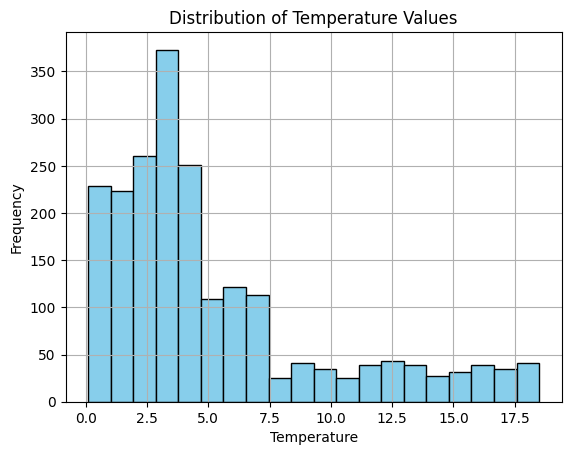

In [186]:
# Distribution graph of temperature values
plt.hist(y_data, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

In [187]:
from collections import Counter

# Count the occurrences of each length in X_data
length_counts = Counter(len(x) for x in X_data)

# Print the count of lists for each unique length
for length, count in length_counts.items():
    print(f"Length {length}: {count} lists")


Length 187: 1850 lists
Length 374: 250 lists


It appeared that some of my data is of twice the length, because of the way I wrote my code in data_generator.py, it appends to an existing list if the temperature value already exists. Although I am surprise this scenario happened when generating random values, it can be dealt with splitting the data points in half to retrieve the 2 simulation runs.

In [188]:
def process_data(X, y):
    X_processed = []
    y_processed = []

    for features, label in zip(X, y):
        if len(features) == 374:
            # Split the list into two parts of equal length 187
            X_processed.append(features[:187])
            X_processed.append(features[187:])
            y_processed.append(label)
            y_processed.append(label)
        else:
            X_processed.append(features)
            y_processed.append(label)

    return np.array(X_processed), np.array(y_processed)

X_processed, y_processed = process_data(X_data, y_data)

print("New shape of X data:", X_processed.shape)
print("New shape of y data:", y_processed.shape)


New shape of X data: (2350, 187)
New shape of y data: (2350,)


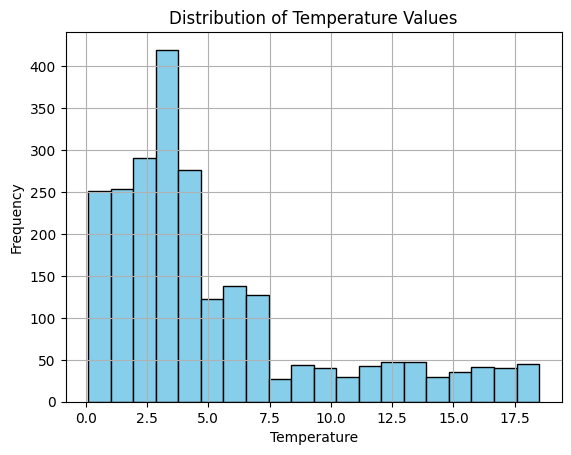

In [189]:
# Plot a distribution graph of temperature values
plt.hist(y_processed, bins=20, color='skyblue', edgecolor='black')
plt.title('Distribution of Temperature Values')
plt.xlabel('Temperature')
plt.ylabel('Frequency')
plt.grid(True)
plt.show()

The distribution of temperatures has not changed too much post-processing, which is great.

### Transforming temperature into classifications

With a value of $T_c = 3.7$, we define 3 classes of temperature ranges

In [190]:
Tc = 3.7

In [191]:
# def temp_range_to_label(temp, Tc):
#     if temp < 0.1 : #should not happen, here just in case
#         return 0
#     elif 0.1 <= temp < 0.5 * Tc:
#         return 0
#     elif 0.5 * Tc <= temp < 0.9 * Tc:
#         return 1
#     elif 0.9 * Tc <= temp < 1.1 * Tc:
#         return 2
#     elif 1.1 * Tc <= temp < 2.0 * Tc:
#         return 3
#     elif 2.0 * Tc <= temp < 5.0 * Tc:
#         return 4
#     else:
#         raise ValueError("Temperature out of range")
    
# y_classification = np.array([temp_range_to_label(temp, Tc) for temp in y_processed])

# # Check the unique class labels
# unique_labels = np.unique(y_classification)
# print("Unique class labels:", unique_labels)

In [192]:
def temp_range_to_label(temp, Tc):
    if temp < 0.75*Tc:
        return 0
    elif 0.75*Tc  <= temp < 1.45 * Tc:
        return 1
    else:
        return 2

y_classification = np.array([temp_range_to_label(temp, Tc) for temp in y_processed])

# Check the unique class labels
unique_labels = np.unique(y_classification)
print("Unique class labels:", unique_labels)


Unique class labels: [0 1 2]


In [193]:
unique, counts = np.unique(y_classification, return_counts=True)
class_distribution = dict(zip(unique, counts))

print("Class Distribution:", class_distribution)

Class Distribution: {0: 778, 1: 798, 2: 774}


In [194]:
y_classification.shape

(2350,)

# Avoiding Overfitting : Transforming the data

In [195]:
X, y = X_processed, y_classification
print(X.shape, '\n', y.shape)

(2350, 187) 
 (2350,)


## Feature Engineering

In [196]:
def add_fourier_features(X):
    # Apply Fourier transform and take absolute values (magnitudes)
    fourier_features = np.abs(np.fft.rfft(X, axis=1))
    
    # Normalize the Fourier features
    fourier_features /= fourier_features.sum(axis=1, keepdims=True)
    
    # Concatenate with the original features 
    X_enhanced = np.concatenate([X, fourier_features], axis=1)
    return X_enhanced

X_fourier = add_fourier_features(X_processed)

print("Original Shape:", X_processed.shape)
print("New Shape with Fourier Features:", X_fourier.shape)

Original Shape: (2350, 187)
New Shape with Fourier Features: (2350, 281)


## Windowing approach to segment each time series and extract more data points

In [197]:
def create_windows(data, window_size, step_size):
    """
    This function creates overlapping windows from the time series data.
    
    Parameters:
        data (np.array): The input time series data (number of instances, time series length).
        window_size (int): The size of each window.
        step_size (int): The step size to move the window.
    
    Returns:
        np.array: An array of windows created from the time series data.
    """
    n_samples = data.shape[0]
    n_windows = (data.shape[1] - window_size) // step_size + 1
    windows = np.zeros((n_samples * n_windows, window_size))

    for i in range(n_samples):
        for j in range(n_windows):
            start = j * step_size
            end = start + window_size
            windows[i * n_windows + j] = data[i, start:end]

    return windows

#  adjust y to match the windows created from X
def adjust_labels_for_windows(y_labels, window_size, step_size, original_length=187):
    n_windows_per_sequence = (original_length - window_size) // step_size + 1
    y_windowed = np.repeat(y_labels, n_windows_per_sequence)
    return y_windowed

# Adjusting y_classification to match the windowed X
window_size = 50
X_windowed = create_windows(X, window_size=window_size, step_size=10)
y_windowed = adjust_labels_for_windows(y_classification, window_size=window_size, step_size=10)

X_windowed.shape, y_windowed.shape 

((32900, 50), (32900,))

## One-hot encoding of classes

In [198]:
import numpy as np

def one_hot_encode(labels, num_classes):
    """
    One-hot encodes the labels.

    Parameters:
        labels (np.array): Array of integer class labels.
        num_classes (int): Total number of classes.

    Returns:
        np.array: One-hot encoded matrix.
    """
    return np.eye(num_classes)[labels]

num_classes = np.unique(y_windowed).size  
y_one_hot = one_hot_encode(y_windowed, num_classes)

print("Shape of y_windowed:", y_windowed.shape)
print("Shape of y_one_hot:", y_one_hot.shape)


Shape of y_windowed: (32900,)
Shape of y_one_hot: (32900, 3)


### Add relevant features 

In [199]:
import numpy as np
from scipy.stats import kurtosis, skew

def add_statistical_features(X):
    """
    Adds statistical features to each window in the dataset.
    
    Parameters:
        X (np.ndarray): The input dataset (number of windows, window size).

    Returns:
        np.ndarray: The enhanced feature set including the original features plus new statistical features.
    """
    # Calculate various statistical measures
    max_values = np.max(X, axis=1, keepdims=True)
    min_values = np.min(X, axis=1, keepdims=True)
    mean_values = np.mean(X, axis=1, keepdims=True)
    std_values = np.std(X, axis=1, keepdims=True)
    # kurtosis_values = kurtosis(X, axis=1, fisher=True, bias=False).reshape(-1, 1)
    # skewness_values = skew(X, axis=1, bias=False).reshape(-1, 1)
    
    # Combine all features
    X_enhanced = np.concatenate([
        X, max_values, min_values, mean_values, std_values, 
    ], axis=1)

    return X_enhanced

# Apply the function to your windowed dataset
X_enhanced = add_statistical_features(X_windowed)

print("Original Shape:", X_windowed.shape)
print("New Shape with Statistical Features:", X_enhanced.shape)

Original Shape: (32900, 50)
New Shape with Statistical Features: (32900, 54)


In [200]:
nan_columns = np.any(np.isnan(X_enhanced), axis=0)
nan_column_indices = np.where(nan_columns)[0]

print("Columns with NaN values:", nan_column_indices)


Columns with NaN values: []


# 4. Model and Training

## Loss Model :

Since we are doing a classification problem, it is natural to use the categorical cross-entropy loss : 
$$
\mathcal{L}_{CE}(\Theta) = - \sum_{i=1}^{N} \sum_{c=1}^{C} y_{ic} \log{\hat{y}_{ic}(\Theta)}
$$
Where:

\begin{itemize}
    \item N is the number of samples in the dataset (=32900 here).
    \item C is the number of classes (3 classes here)
    \item  $y_{ic}$is a binary indicator (0 or 1) if class label $c$ is the correct classification for observation $i$.
    \item $\hat{y}_{ic}(\Theta)$ is the predicted probability of observation $i$ being of class $c$ , computed by the MLP model with parameters $\Theta$.
\end{itemize}

In this study, the cross-entropy loss function was selected for the MLP classifier due to its robust performance in multi-class classification tasks, which aligns with our objective to categorize market temperatures based on Ising model simulations. This choice is particularly apt as it not only quantifies the divergence between predicted probabilities and actual class labels, but also maximizes the likelihood of the observed data under the model—a key consideration given the probabilistic outputs required for effectively simulating market behaviors. By adopting cross-entropy, the model is encouraged to enhance both the accuracy and confidence of its predictions, crucial for the nuanced analysis of econophysics-based market simulations.

\subsubsection{Model training}

The training of the MLP classifier in this project is supervised, as it involves using labeled data where each input (a time-series of market temperatures derived from Ising model simulations) is associated with a specific class label (categorized temperature ranges). It is a classification problem, and not regression, since the objective is to categorize each input into one of the three  categories representing the different temperature regimes.

The loss landscape of the MLP used in this study is expected to be non-convex. This is typical for neural networks due to their complex architectures and the nature of the activation functions used, such as ReLU in our case. Non-convex landscapes can have multiple local minima and saddle points, which can make training more challenging

The MLP model is trained using the backpropagation algorithm. Backpropagation efficiently computes the gradients of the loss function with respect to each weight in the network by applying the chain rule of calculus, propagating errors back through the network. Below is a pedagogical breakdown:

\begin{enumerate}
    \item \textbf{Initialization:} Weights and biases in the MLP are initialized randomly.
    \item \textbf{Forward Pass:} Each input batch is passed forward through the network layers. Neurons apply a weighted sum on inputs, followed by an activation function (ReLU in this case) to introduce non-linearity, allowing the network to learn complex patterns.
    \item \textbf{Loss Calculation:} After the forward pass, the output is compared to the true labels using the cross-entropy loss function. This function quantifies the difference between the predicted class probabilities and the actual class labels.
    \item \textbf{Backward Pass (Backpropagation):} The gradient of the loss function with respect to each weight is calculated, starting from the output layer and moving backwards through the network. This step is crucial as it informs how much and in which direction each weight should be adjusted to minimize the error.
    \item \textbf{Weight Update:} Weights are updated using the gradients calculated during backpropagation. The update is typically performed using SGD, where a learning rate parameter controls how big a step is taken in the direction opposite to the gradient. Variants of SGD, like Adam (used in this project), can also be employed to adapt the learning rates based on past gradients, which can lead to faster convergence in practice.
    \item \textbf{Iteration:} This process is repeated for multiple iterations (epochs) over the dataset, with each iteration aiming to reduce the overall loss. Each epoch goes through the entire dataset once.
    \item \textbf{Regularization and Dropout:} To avoid overfitting, especially in a complex model trained on potentially noisy financial data, techniques like dropout are used. Dropout randomly disables a fraction of neurons during training, which helps to make the network robust to noise and forces it to learn more generalized features.
\end{enumerate}

By carefully executing the above steps, the MLP model learns to categorize the input temperature data into distinct classes corresponding to different market behaviors predicted by the Ising model. This structured approach ensures that the model is not only trained to minimize the training error but also to generalize well on unseen data.

# Building an MLP with PyTorch

In [201]:
X,y = X_enhanced, y_one_hot
print(X.shape, '\n', y.shape)

(32900, 54) 
 (32900, 3)


### 1. Normalizing the data

In [202]:
from sklearn.preprocessing import StandardScaler

scaler = StandardScaler()
X_scaled = scaler.fit_transform(X_enhanced)  


### Training and Test Sets

In [203]:
from sklearn.model_selection import train_test_split

# Split the data
X_train, X_test, y_train, y_test = train_test_split(X_scaled, y, test_size=0.2, random_state=42)


In [204]:
# Check for NaN or Inf in X and y after scaling and transforming
print("NaN in X_train:", np.isnan(X_train).any())
print("Inf in X_train:", np.isinf(X_train).any())
print("NaN in y_train:", np.isnan(y_train).any())
print("Inf in y_train:", np.isinf(y_train).any())


NaN in X_train: False
Inf in X_train: False
NaN in y_train: False
Inf in y_train: False


### 3. Convert Data to PyTorch Tensors

In [205]:
X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

### 4. Define the MLP model

In [206]:
class MLP(nn.Module):
    def __init__(self, input_size, num_classes):
        super(MLP, self).__init__()
        self.layer1 = nn.Linear(input_size, 128)
        self.layer2 = nn.Linear(128, 64)
        self.dropout = nn.Dropout(0.6)
        self.output = nn.Linear(64, num_classes)

    def forward(self, x):
        x = torch.relu(self.layer1(x))
        x = self.dropout(x)
        x = torch.relu(self.layer2(x))
        return self.output(x)

# Initialize the model
input_size = X_train_tensor.shape[1]
num_classes = y_train_tensor.shape[1]
model = MLP(input_size, num_classes)

### 5. Loss Function and Optimizer

In [207]:
from torch import optim

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
model.to(device)

# loss function and optimizer
criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(model.parameters(), lr=0.001, weight_decay=1e-4)


### 6. Data Loaders


In [208]:
from torch.utils.data import DataLoader, TensorDataset

# Prepare data loaders
train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_loader = DataLoader(train_dataset, batch_size=64, shuffle=True)

test_dataset = TensorDataset(X_test_tensor, y_test_tensor)
test_loader = DataLoader(test_dataset, batch_size=64, shuffle=False)


### 7. Train and Evaluate model

In [209]:
def train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50):
    model.to(device)
    history = {'train_loss': [], 'train_acc': [], 'test_loss': [], 'test_acc': []}

    for epoch in range(num_epochs):
        model.train()
        train_loss = 0
        correct = 0
        total = 0

        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

            train_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(targets, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

        train_acc = 100 * correct / total
        history['train_loss'].append(train_loss / len(train_loader))
        history['train_acc'].append(train_acc)

        test_loss, test_acc = evaluate_model(model, test_loader, criterion)
        history['test_loss'].append(test_loss)
        history['test_acc'].append(test_acc)
        if epoch % 10 == 0 :
            print(f'Epoch {epoch+1}: Train Loss: {train_loss / len(train_loader):.4f}, Train Acc: {train_acc:.2f}%, Test Loss: {test_loss:.4f}, Test Acc: {test_acc:.2f}%')

    return history

def evaluate_model(model, test_loader, criterion):
    model.eval()
    test_loss = 0
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in test_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            loss = criterion(outputs, targets)
            test_loss += loss.item()
            _, predicted = torch.max(outputs.data, 1)
            _, labels = torch.max(targets, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    test_acc = 100 * correct / total
    return test_loss / len(test_loader), test_acc


Epoch 1: Train Loss: 0.7876, Train Acc: 56.51%, Test Loss: 0.7281, Test Acc: 59.24%
Epoch 11: Train Loss: 0.5043, Train Acc: 78.01%, Test Loss: 0.4482, Test Acc: 82.34%
Epoch 21: Train Loss: 0.4645, Train Acc: 79.98%, Test Loss: 0.4212, Test Acc: 82.71%
Epoch 31: Train Loss: 0.4516, Train Acc: 80.89%, Test Loss: 0.4098, Test Acc: 82.99%
Epoch 41: Train Loss: 0.4363, Train Acc: 81.53%, Test Loss: 0.4109, Test Acc: 82.60%


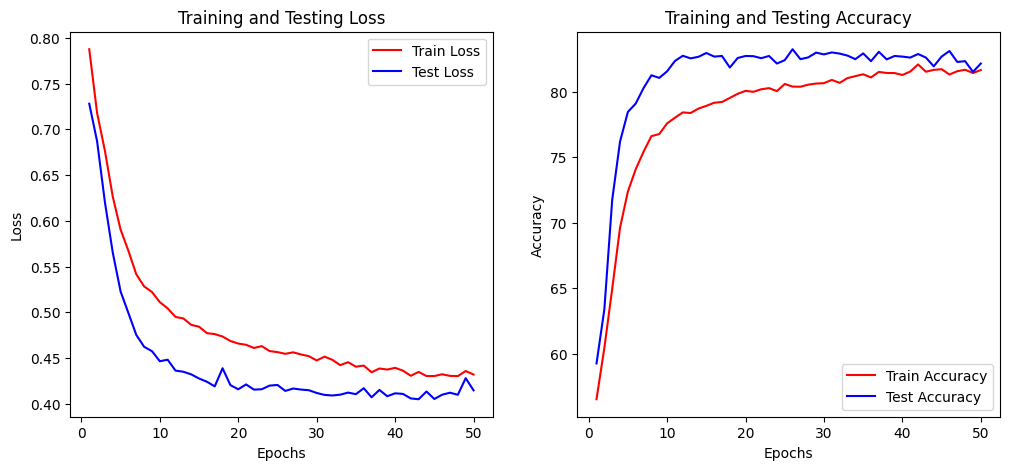

In [210]:
import matplotlib.pyplot as plt

def plot_training_history(history):
    epochs = range(1, len(history['train_loss']) + 1)
    plt.figure(figsize=(12, 5))

    plt.subplot(1, 2, 1)
    plt.plot(epochs, history['train_loss'], 'r-', label='Train Loss')
    plt.plot(epochs, history['test_loss'], 'b-', label='Test Loss')
    plt.title('Training and Testing Loss')
    plt.xlabel('Epochs')
    plt.ylabel('Loss')
    plt.legend()

    plt.subplot(1, 2, 2)
    plt.plot(epochs, history['train_acc'], 'r-', label='Train Accuracy')
    plt.plot(epochs, history['test_acc'], 'b-', label='Test Accuracy')
    plt.title('Training and Testing Accuracy')
    plt.xlabel('Epochs')
    plt.ylabel('Accuracy')
    plt.legend()

    plt.show()

history = train_model(model, train_loader, test_loader, criterion, optimizer, num_epochs=50)
plot_training_history(history)


In [211]:
import numpy as np
import torch
from torch import nn, optim
from torch.utils.data import DataLoader, TensorDataset
from sklearn.model_selection import KFold
from sklearn.preprocessing import StandardScaler

# Assuming the following variables are defined:
# X_fourier: input features after Fourier transformation and any preprocessing
# y_classification: target labels prepared as class indices

# Parameters
num_classes = np.unique(y_classification).size
input_size = X_fourier.shape[1]
num_folds = 5
num_epochs = 50
batch_size = 64

# Initialize K-Fold cross-validation
kf = KFold(n_splits=num_folds, shuffle=True, random_state=42)

# Scaler for data normalization
scaler = StandardScaler()

# To store each fold's accuracy
accuracies = []

for fold, (train_idx, val_idx) in enumerate(kf.split(X_fourier)):
    X_train, X_val = X_fourier[train_idx], X_fourier[val_idx]
    y_train, y_val = y_classification[train_idx], y_classification[val_idx]

    # Data normalization
    X_train = scaler.fit_transform(X_train)
    X_val = scaler.transform(X_val)

    # Convert arrays to tensors
    X_train_tensor = torch.tensor(X_train, dtype=torch.float32)
    y_train_tensor = torch.tensor(y_train, dtype=torch.long)
    X_val_tensor = torch.tensor(X_val, dtype=torch.float32)
    y_val_tensor = torch.tensor(y_val, dtype=torch.long)

    # Create Tensor datasets
    train_dataset = TensorDataset(X_train_tensor, y_train_tensor)
    val_dataset = TensorDataset(X_val_tensor, y_val_tensor)

    # Data loaders
    train_loader = DataLoader(train_dataset, batch_size=batch_size, shuffle=True)
    val_loader = DataLoader(val_dataset, batch_size=batch_size)

    # Initialize model
    model = MLP(input_size, num_classes).to(device)

    # Loss and optimizer
    criterion = nn.CrossEntropyLoss()
    optimizer = optim.Adam(model.parameters(), lr=0.001)

    # Training loop
    for epoch in range(num_epochs):
        model.train()
        for data, targets in train_loader:
            data, targets = data.to(device), targets.to(device)
            optimizer.zero_grad()
            outputs = model(data)
            loss = criterion(outputs, targets)
            loss.backward()
            optimizer.step()

    # Validation loop
    model.eval()
    correct = 0
    total = 0
    with torch.no_grad():
        for data, targets in val_loader:
            data, targets = data.to(device), targets.to(device)
            outputs = model(data)
            _, predicted = torch.max(outputs.data, 1)
            total += targets.size(0)
            correct += (predicted == targets).sum().item()

    fold_accuracy = correct / total
    accuracies.append(fold_accuracy)
    print(f"Fold {fold+1} Accuracy: {fold_accuracy:.4f}")

# Average accuracy across all folds
average_accuracy = np.mean(accuracies)
print(f"Average Cross-Validation Accuracy: {average_accuracy:.4f}")


Fold 1 Accuracy: 0.8383
Fold 2 Accuracy: 0.8511
Fold 3 Accuracy: 0.8574
Fold 4 Accuracy: 0.8340
Fold 5 Accuracy: 0.8234
Average Cross-Validation Accuracy: 0.8409


# 5. Validation 
The MLP model was validated using k-fold cross-validation with k=5. This approach involves partitioning the data into k equal-sized subsets. For each validation, the model is trained on k−1 subsets while the remaining subset is used as the test set. This cycle is repeated k times with each subset used exactly once as the test set. K-fold cross-validation helps in ensuring that the model’s performance is reliable and consistent across different subsets of the data, reducing the likelihood of anomalies due to any particular random split.

We can see that my model was starting to overfit, which was a recurrent problem during the training of my model.
However by adjusting the number of layers and neurons, the dropout rate, and adding a weight decay, I was able to considerably disminish overfitting.

The generalizability of the model beyond the training dataset was tested by evaluating its performance on a separate validation set that was not used during the training phase. This set was chosen to represent potential real-world applications to ensure that the model can perform well in practical scenarios, not just in controlled experiment settings. The ability of the model to maintain high performance on this external dataset provides a good indication of its generalizability.


# 6.White-boxing the Model

the MLP model, trained on market behavior data simulated using the Ising model, learned to classify different temperature ranges based on the input features being the log-return. Through supervised training, the model was taught to map the input data to specific categories representing market behaviors at various temperature regimes. To ensure its reliability, the model's performance was rigorously evaluated using k-fold cross-validation, assessing both training and validation accuracies to guard against overfitting or underfitting.

Regarding what the model learned, it essentially created decision boundaries in a transformed latent space, marking different market temperature ranges. These decision boundaries were established by adjusting the weights and biases of the neurons in the hidden layers during training. The model's ability to accurately classify market behaviors beyond the training dataset suggests it learned generalized patterns rather than merely memorizing the training examples. 

# 7.Insights

Throughout my project, I've gained significant insights at the intersection of econophysics and machine learning. By simulating market models using the Ising model, I've developed a deeper understanding of how temperature regimes, derived from these simulations, relate to specific market states. This exploration has provided valuable insights into the complex dynamics governing financial markets, revealing nuanced relationships between variables influencing market behavior.

Moreover, through training an MLP classifier on the Ising model data, I've discovered the model's ability to effectively learn and represent complex patterns within financial data. I've observed how the MLP can discern subtle relationships between market variables and categorize them into distinct temperature ranges, showcasing the power of machine learning in uncovering hidden structures within intricate datasets. However, grappling with interpreting the model's learned representations highlights the ongoing challenge of creating transparent and interpretable machine learning models, especially in finance, where understanding underlying mechanisms is crucial.

Overall I am glad to have taken this challenging project, slightly different than the intended homework but very simulating. 